**OlabisiDS Notebook**

Exploration Envinronment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn

In [2]:
df = pd.read_csv("/content/train[1].csv")
df.head()

,date,store,item,sales
0,2013-01-01,1.0,1.0,13.0
1,2013-01-02,1.0,1.0,11.0
2,2013-01-03,1.0,1.0,14.0
3,2013-01-04,1.0,1.0,13.0
4,2013-01-05,1.0,1.0,10.0


In [3]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173155 entries, 0 to 173154
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    173155 non-null  object 
 1   store   173154 non-null  float64
 2   item    173154 non-null  float64
 3   sales   173154 non-null  float64
dtypes: float64(3), object(1)
memory usage: 5.3+ MB


In [4]:
df.duplicated().sum()

0

In [5]:
def column_summary(data):
  col = []
  dtype = []
  unique = []
  nunique = []
  duplicated = []
  null = []

  for column in data.columns:
    col.append(column)
    dtype.append(data[column].dtype)
    unique.append(data[column].unique())
    nunique.append(data[column].nunique())
    duplicated.append(data[column].duplicated().sum())
    null.append(data[column].isnull().sum())

  return pd.DataFrame({"Column": col, "Dtype": dtype, "Unique": unique,
                       "Nunique": nunique, "Duplicated Values": duplicated, "Null Values": null})

In [6]:
column_summary(df)

,Column,Dtype,Unique,Nunique,Duplicated Values,Null Values
0,date,object,"[2013-01-01, 2013-01-02, 2013-01-03, 2013-01-0...",1827,171328,0
1,store,float64,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",10,173144,1
2,item,float64,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",10,173144,1
3,sales,float64,"[13.0, 11.0, 14.0, 10.0, 12.0, 9.0, 7.0, 5.0, ...",178,172976,1


In [7]:
df = df.dropna()

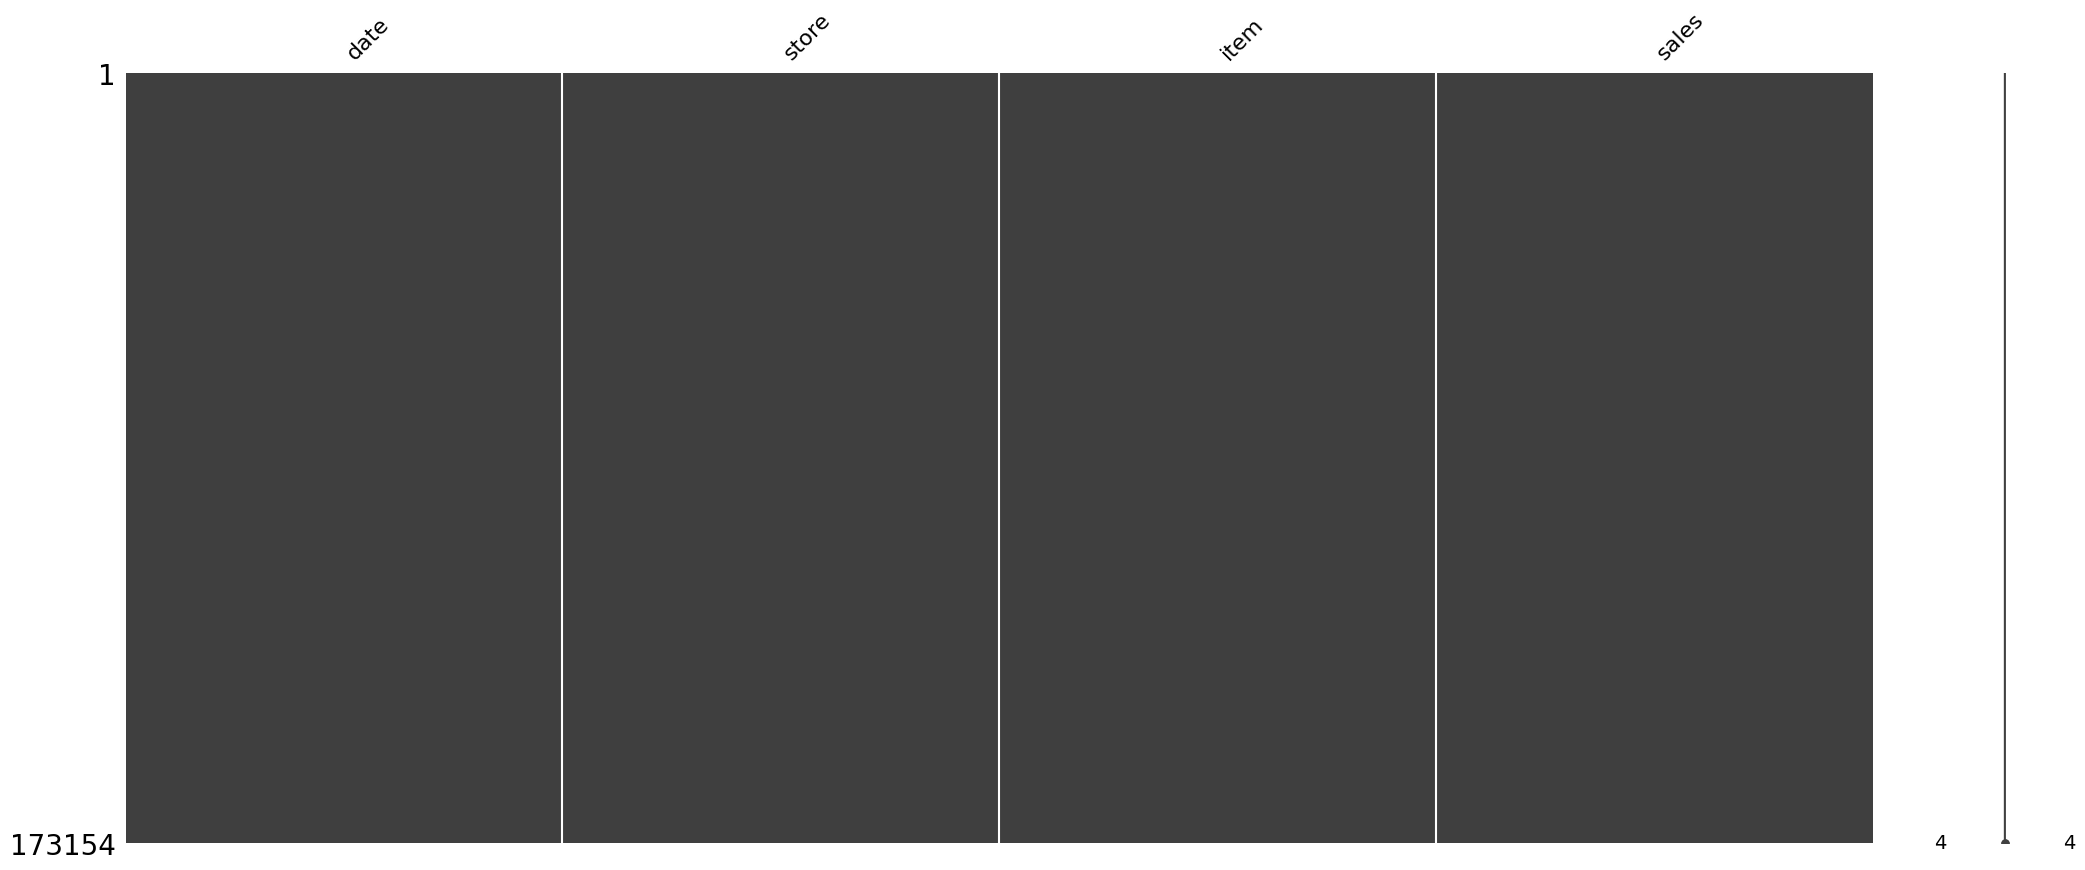

In [8]:
#Confirming absence of missing values
msn.matrix(df);

In [9]:
#Convert the date column from object to datetime
df['date'] = pd.to_datetime(df['date'])

#Extract additional features from the date column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [10]:
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1.0,1.0,13.0,2013,1,1
1,2013-01-02,1.0,1.0,11.0,2013,1,2
2,2013-01-03,1.0,1.0,14.0,2013,1,3
3,2013-01-04,1.0,1.0,13.0,2013,1,4
4,2013-01-05,1.0,1.0,10.0,2013,1,5


In [11]:
df = df.drop(columns="date", axis=1)
column_summary(df)

,Column,Dtype,Unique,Nunique,Duplicated Values,Null Values
0,store,float64,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",10,173144,0
1,item,float64,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",10,173144,0
2,sales,float64,"[13.0, 11.0, 14.0, 10.0, 12.0, 9.0, 7.0, 5.0, ...",178,172976,0
3,year,int32,"[2013, 2014, 2015, 2016, 2017]",5,173149,0
4,month,int32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",12,173142,0
5,day,int32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",31,173123,0


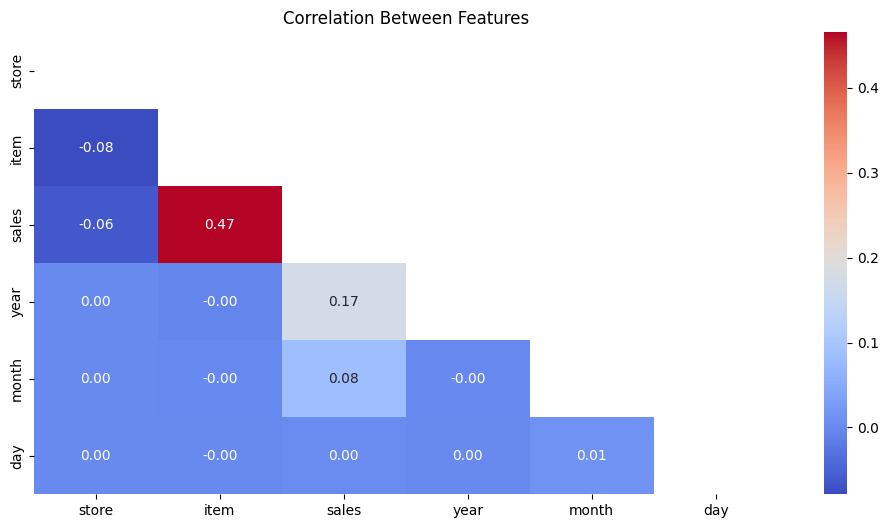

In [12]:
#Checking for correlation between features
corr = df.corr()
mask = np.triu(corr)
plt.figure(figsize=(12,6))
sns.heatmap(corr,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            fmt='.2f')
plt.title("Correlation Between Features")
plt.show();

**Modelling**

Modellinng Environment Setup

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from xgboost import XGBRegressor

In [14]:
X = df.drop(columns="sales", axis=1)
y = df["sales"]

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

#Further split the test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("X_val Shape:", X_val.shape)
print("y_val Shape:", y_val.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (121207, 5)
y_train Shape: (121207,)
X_val Shape: (25973, 5)
y_val Shape: (25973,)
X_test Shape: (25974, 5)
y_test Shape: (25974,)


In [15]:
def objective(space):
    reg = XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree']
    )

    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)], eval_metric="rmse",
            early_stopping_rounds=10, verbose=False)

    pred = reg.predict(X_test)

    mse = mean_squared_error(y_test, pred)
    print("MSE:", mse)

    return {'loss': mse, 'status': STATUS_OK}

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 1000, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'reg_alpha': hp.quniform('reg_alpha', 0, 100, 1),
    'reg_lambda': hp.quniform('reg_lambda', 0, 100, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1)
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best parameters:", best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
67.25789867938228
  2%|▏         | 1/50 [00:33<27:31, 33.71s/trial, best loss: 67.25789867938228]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
74.86415005171274
  4%|▍         | 2/50 [00:34<11:36, 14.50s/trial, best loss: 67.25789867938228]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
63.85790573528632
  6%|▌         | 3/50 [00:38<07:28,  9.54s/trial, best loss: 63.85790573528632]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
75.18236579141781
  8%|▊         | 4/50 [00:39<04:41,  6.11s/trial, best loss: 63.85790573528632]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
127.35431303899674
 10%|█         | 5/50 [00:40<03:16,  4.36s/trial, best loss: 63.85790573528632]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
90.31198487098544
 12%|█▏        | 6/50 [00:42<02:32,  3.47s/trial, best loss: 63.85790573528632]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
59.57886599698975
 14%|█▍        | 7/50 [00:44<02:09,  3.02s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
90.33604917546204
 16%|█▌        | 8/50 [00:45<01:44,  2.50s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
90.03623141275949
 18%|█▊        | 9/50 [00:47<01:30,  2.21s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
86.64723348250851
 20%|██        | 10/50 [00:53<02:18,  3.46s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
86.58961795277717
 22%|██▏       | 11/50 [00:57<02:16,  3.50s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
84.22942658618256
 24%|██▍       | 12/50 [00:58<01:42,  2.71s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
65.6933174270714
 26%|██▌       | 13/50 [00:59<01:22,  2.23s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
127.35273651691445
 28%|██▊       | 14/50 [01:00<01:08,  1.89s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
83.58696241449829
 30%|███       | 15/50 [01:04<01:29,  2.55s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
86.24451602283284
 32%|███▏      | 16/50 [01:08<01:38,  2.91s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
127.35489584782427
 34%|███▍      | 17/50 [01:09<01:18,  2.38s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
60.35362822676346
 36%|███▌      | 18/50 [01:10<01:06,  2.09s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
61.68647392268557
 38%|███▊      | 19/50 [01:12<01:06,  2.15s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
76.38367515724272
 40%|████      | 20/50 [01:16<01:15,  2.51s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
90.33296483240554
 42%|████▏     | 21/50 [01:17<01:00,  2.08s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
67.35209861925834
 44%|████▍     | 22/50 [01:18<00:53,  1.91s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
90.36374411044322
 46%|████▌     | 23/50 [01:19<00:44,  1.65s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
62.271387912566865
 48%|████▊     | 24/50 [01:21<00:41,  1.61s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
90.33354226988021
 50%|█████     | 25/50 [01:22<00:36,  1.45s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
65.370450728255
 52%|█████▏    | 26/50 [01:23<00:34,  1.46s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
80.38477256827831
 54%|█████▍    | 27/50 [01:24<00:28,  1.25s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
62.99080670204571
 56%|█████▌    | 28/50 [01:28<00:46,  2.10s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
66.39404252960857
 58%|█████▊    | 29/50 [01:30<00:40,  1.92s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
90.2405255162615
 60%|██████    | 30/50 [01:31<00:33,  1.68s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
62.51767523761869
 62%|██████▏   | 31/50 [01:33<00:31,  1.66s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
90.23282989041563
 64%|██████▍   | 32/50 [01:34<00:27,  1.50s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
71.06177019209731
 66%|██████▌   | 33/50 [01:35<00:23,  1.37s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
90.26954985311633
 68%|██████▊   | 34/50 [01:36<00:20,  1.31s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
74.91507081988738
 70%|███████   | 35/50 [01:37<00:18,  1.20s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
80.7260424014526
 72%|███████▏  | 36/50 [01:39<00:20,  1.48s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
61.7455207109657
 74%|███████▍  | 37/50 [01:42<00:26,  2.05s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
76.67735471716868
 76%|███████▌  | 38/50 [01:44<00:21,  1.77s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
66.32252749017188
 78%|███████▊  | 39/50 [01:46<00:22,  2.02s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
86.33484183359062
 80%|████████  | 40/50 [01:50<00:25,  2.55s/trial, best loss: 59.57886599698975]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
59.52438839575549
 82%|████████▏ | 41/50 [01:54<00:28,  3.16s/trial, best loss: 59.52438839575549]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
59.091740152252406
 84%|████████▍ | 42/50 [01:57<00:24,  3.05s/trial, best loss: 59.091740152252406]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
93.19841562775743
 86%|████████▌ | 43/50 [01:59<00:18,  2.69s/trial, best loss: 59.091740152252406]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
78.83472844978759
 88%|████████▊ | 44/50 [02:00<00:12,  2.15s/trial, best loss: 59.091740152252406]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
59.218579575070635
 90%|█████████ | 45/50 [02:04<00:12,  2.59s/trial, best loss: 59.091740152252406]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
61.53790801981225
 92%|█████████▏| 46/50 [02:10<00:14,  3.66s/trial, best loss: 59.091740152252406]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
60.77212041037493
 94%|█████████▍| 47/50 [02:12<00:09,  3.19s/trial, best loss: 59.091740152252406]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
92.80132695923204
 96%|█████████▌| 48/50 [02:12<00:04,  2.35s/trial, best loss: 59.091740152252406]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
82.57018655254885
 98%|█████████▊| 49/50 [02:13<00:01,  1.91s/trial, best loss: 59.091740152252406]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



MSE:
69.73184765347312
100%|██████████| 50/50 [02:14<00:00,  2.70s/trial, best loss: 59.091740152252406]
Best parameters: {'colsample_bytree': 0.9275924691098683, 'gamma': 0.7731716321102176, 'max_depth': 15.0, 'min_child_weight': 19.0, 'n_estimators': 430.0, 'reg_alpha': 46.0, 'reg_lambda': 97.0}


In [16]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Train Set Mean Squared Error: {train_mse}")
    print(f"Train Set R2 Score: {train_r2:.2f}")
    print(f"Test Set Mean Squared Error: {test_mse}")
    print(f"Test Set R2 Score: {test_r2:.2f}")

#Convert best parameters to correct types
best_params = {key: int(value) if key not in ['gamma', 'colsample_bytree'] else value for key, value in best.items()}

#Fit final model
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

#Evaluate model
evaluate_model(final_model, X_train, X_test, y_train, y_test)

Train Set Mean Squared Error: 47.47744570884975
Train Set R2 Score: 0.93
Test Set Mean Squared Error: 59.11328782812529
Test Set R2 Score: 0.92


In [17]:
#Perform cross-validation
scores = cross_val_score(final_model, X_val, y_val, cv=5)

print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

Cross-validation scores: [0.87916749 0.87305535 0.88152394 0.87781435 0.87946172]
Mean accuracy: 0.8782045703613383
